# Predição de Doações de Sangue

*Give Life: Predict Blood Donations*

*Projeto guiado criado por Dimitri Denisjonok e distribuído pela DataCamp.*

*Adaptado por Caíque de Oliveira de forma exploratória.*

## Introdução

Nosso conjunto de dados vem de um veículo móvel de doação de sangue em Taiwan. O Centro de Serviços de Transfusão de Sangue vai até diferentes universidades e coleta sangue como parte de uma doação de sangue. Queremos prever se um doador doará sangue ou não na próxima vez que o veículo chegar ao campus.

Os dados foram originalmente armazenados em transfusion.data que um formato de acordo com o modelo de marketing RFMTC (uma variação do RFM). Não exploraremos o que é isso neste caderno. Dito isso, vamos inspecionar os dados.

## 1. Inspecionando Dados de Transfusão

In [ ]:
# Import pandas
import pandas as pd

# Read in dataset
url = "https://raw.githubusercontent.com/Oliveira-Caique/Data-Science/main/Predicao_de_Doacoes_de_Sangue/transfusion.csv"
transfusion = pd.read_csv(url)

# Print out the first rows of our dataset
transfusion.head()

,Unnamed: 0,Recency,Frequency,Monetary,Time,whether they donated blood in March 2007
0,0,2,50,12500,98,2
1,1,0,13,3250,28,2
2,2,1,16,4000,35,2
3,3,2,20,5000,45,2
4,4,1,24,6000,77,1


In [ ]:
transfusion = transfusion.drop("Unnamed: 0", axis = 1)
transfusion

,Recency,Frequency,Monetary,Time,whether they donated blood in March 2007
0,2,50,12500,98,2
1,0,13,3250,28,2
2,1,16,4000,35,2
3,2,20,5000,45,2
4,1,24,6000,77,1
...,...,...,...,...,...
743,23,2,500,38,1
744,21,2,500,52,1
745,23,3,750,62,1
746,39,1,250,39,1


Voltemos brevemente à nossa discussão sobre o modelo RFM. RFM significa Recência, Frequência e Valor Monetário e é comumente usado em marketing para identificar seus melhores clientes. No nosso caso, nossos clientes são doadores de sangue.

RFMTC é uma variação do modelo RFM. Abaixo está uma descrição do que cada coluna significa em nosso conjunto de dados:

* R (Recência - meses desde a última doação)
* F (Frequência - número total de doações)
* M (Monetário - total de sangue doado em c.c.)
* T (Tempo - meses desde a primeira doação)

uma variável binária que representa se ele/ela doou sangue em março de 2007 (2 significa doar sangue; 1 significa não doar sangue)
Parece que todas as colunas do nosso DataFrame possuem o tipo numérico, que é exatamente o que queremos ao construir um modelo de aprendizado de máquina. Vamos verificar nossa hipótese.

In [ ]:
transfusion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column                                    Non-Null Count  Dtype
---  ------                                    --------------  -----
 0   Recency                                   748 non-null    int64
 1   Frequency                                 748 non-null    int64
 2   Monetary                                  748 non-null    int64
 3   Time                                      748 non-null    int64
 4   whether they donated blood in March 2007  748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


Nosso objetivo é prever o valor da doação de sangue na coluna de março de 2007. Vamos renomeá-lo para target para que seja mais conveniente trabalhar.

In [ ]:
column_dict = {"whether they donated blood in March 2007": "Target"}

transfusion.rename(
    columns=column_dict,
    inplace=True
)

# Print out the first 2 rows
transfusion.iloc[:2]

,Recency,Frequency,Monetary,Time,Target
0,2,50,12500,98,2
1,0,13,3250,28,2


In [ ]:
transfusion.describe()

,Recency,Frequency,Monetary,Time,Target
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086,1.237968
std,8.095396,5.839307,1459.826781,24.376714,0.426124
min,0.000000,1.000000,250.000000,2.000000,1.000000
25%,2.750000,2.000000,500.000000,16.000000,1.000000
50%,7.000000,4.000000,1000.000000,28.000000,1.000000
75%,14.000000,7.000000,1750.000000,50.000000,1.000000
max,74.000000,50.000000,12500.000000,98.000000,2.000000


In [ ]:
transfusion.Target.value_counts(normalize = True)

1    0.762032
2    0.237968
Name: Target, dtype: float64

## Polindo os Dados e Escolhendo um Modelo

A incidência alvo nos informou que em nosso conjunto de dados 0s aparecem 76% das vezes. Queremos manter a mesma estrutura nos conjuntos de dados de treinamento e teste, ou seja, ambos os conjuntos de dados devem ter 0 incidência alvo de 76%. Isso é muito fácil de fazer usando o método `train_test_split()` da biblioteca *scikit learn* - tudo o que precisamos fazer é especificar o parâmetro *stratify*. No nosso caso, estratificaremos na coluna de destino.

In [ ]:
from sklearn.model_selection import train_test_split

X = transfusion.drop(columns='Target')
y = transfusion.Target

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify= y
)

X_train.iloc[:2]

,Recency,Frequency,Monetary,Time
334,16,2,500,16
99,5,7,1750,26


TPOT é uma ferramenta Python Automated Machine Learning que otimiza pipelines de aprendizado de máquina.

O TPOT explorará automaticamente centenas de pipelines possíveis para encontrar o melhor para nosso conjunto de dados. Observe que o resultado desta pesquisa será um pipeline scikit-learn, o que significa que incluirá todas as etapas de pré-processamento, bem como o modelo.

In [ ]:
! pip install tpot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11937 sha256=87ab466cefc59407ca5a8b0040b8d45b451b1035323835acdf8c345fdd57c155
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit


In [ ]:
# Import TPOTClassifier and roc_auc_score
from tpot import TPOTClassifier
from sklearn.metrics import roc_auc_score

# Instantiate TPOTClassifier
tpot = TPOTClassifier(
    generations=5,
    population_size=20,
    verbosity=2,
    scoring='roc_auc',
    random_state=42,
    disable_update_check=True,
    config_dict='TPOT light'
)

tpot.fit(X_train, y_train)

# AUC score for tpot model
tpot_auc_score = roc_auc_score(y_test, tpot.predict_proba(X_test)[:, 1])
print(f'\nAUC score: {tpot_auc_score:.4f}')

# Print best pipeline steps
print('\nBest pipeline steps:', end='\n')
for idx, (name, transform) in enumerate(tpot.fitted_pipeline_.steps, start=1):
    # Print idx and transform
    print(f'{idx}. {transform}')

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7422459184429089

Generation 2 - Current best internal CV score: 0.7431828935112108

Generation 3 - Current best internal CV score: 0.7431828935112108

Generation 4 - Current best internal CV score: 0.7453756903278108

Generation 5 - Current best internal CV score: 0.7453756903278108

Best pipeline: LogisticRegression(GaussianNB(ZeroCount(input_matrix)), C=25.0, dual=False, penalty=l2)

AUC score: 0.7862

Best pipeline steps:
1. ZeroCount()
2. StackingEstimator(estimator=GaussianNB())
3. LogisticRegression(C=25.0, random_state=42)


O TPOT escolheu LogisticRegression como o melhor modelo para nosso conjunto de dados sem etapas de pré-processamento, dando-nos a pontuação AUC de 0,7850. Este é um ótimo ponto de partida. Vamos ver se podemos melhorar.

A correção para alta variância é chamada de normalização. É uma das possíveis transformações que você faz antes de treinar um modelo. Vamos verificar a variação para ver se tal transformação é necessária.

In [ ]:
X_train.var().round(3)

Recency           66.929
Frequency         33.830
Monetary     2114363.700
Time             611.147
dtype: float64

In [ ]:
# Import numpy
import numpy as np

# Copy X_train and X_test into X_train_normed and X_test_normed
X_train_normed, X_test_normed = X_train.copy(), X_test.copy()

# Specify which column to normalize
col_to_normalize = "Monetary"

# Log normalization
for df_ in [X_train_normed, X_test_normed]:
    # Add log normalized column
    df_['Monetary'] = np.log(df_[col_to_normalize])
    # Drop the original column
    #df_.drop(columns=col_to_normalize, inplace=True)

# Check the variance for X_train_normed
X_train_normed.var().round(3)

Recency       66.929
Frequency     33.830
Monetary       0.837
Time         611.147
dtype: float64

A variação parece muito melhor agora. Observe que agora o Tempo (meses) tem a maior variância, mas não é ordens de magnitude maior que o resto das variáveis, então vamos deixar como está.

Agora estamos prontos para treinar o modelo de regressão logística.

In [ ]:
# Importing modules
from sklearn import linear_model

# Instantiate LogisticRegression
logreg = linear_model.LogisticRegression(
    solver='liblinear',
    random_state=42
)

# Train the model
logreg.fit(X_train_normed, y_train)

# AUC score for tpot model
logreg_auc_score = roc_auc_score(y_test, logreg.predict_proba(X_test_normed)[:, 1])
print(f'\nAUC score: {logreg_auc_score:.4f}')


AUC score: 0.7891


In [ ]:
from sklearn.metrics import classification_report

y_pred = logreg.predict(X_test_normed)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.78      0.98      0.87       143
           2       0.62      0.11      0.19        44

    accuracy                           0.78       187
   macro avg       0.70      0.55      0.53       187
weighted avg       0.75      0.78      0.71       187



A demanda por sangue varia ao longo do ano. Como um exemplo proeminente, as doações de sangue diminuem durante os períodos de férias movimentadas. Uma previsão precisa para o fornecimento futuro de sangue permite que uma ação apropriada seja tomada antecipadamente e, portanto, salve mais vidas.

Neste notebook, exploramos a seleção automática de modelos usando TPOT e a pontuação AUC que obtivemos foi de 0,7850. Isto é melhor do que simplesmente escolher 0 o tempo todo (a incidência alvo sugere que tal modelo teria uma taxa de sucesso de 76%). Em seguida, normalizamos nossos dados de treinamento e melhoramos a pontuação AUC em 0,5%. No campo do aprendizado de máquina, mesmo pequenas melhorias na precisão podem ser importantes, dependendo da finalidade.

Outro benefício do uso do modelo de regressão logística é que ele é interpretável. Podemos analisar quanto da variância na variável resposta (alvo) pode ser explicada por outras variáveis em nosso conjunto de dados.


## Indo além

In [ ]:
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(linear_model.LogisticRegression(), max_samples=0.5, max_features=0.5)

bagging.fit(X_train_normed, y_train)

# AUC score for tpot model
bagging_auc_score = roc_auc_score(y_test, bagging.predict_proba(X_test_normed)[:, 1])
print(f'\nAUC score: {logreg_auc_score:.4f}')
print()

y_pred = bagging.predict(X_test_normed)

print(classification_report(y_test, y_pred))
# ...


AUC score: 0.7891

              precision    recall  f1-score   support

           1       0.78      0.99      0.87       143
           2       0.75      0.07      0.12        44

    accuracy                           0.78       187
   macro avg       0.76      0.53      0.50       187
weighted avg       0.77      0.78      0.70       187



O método de agragadr modelos preditivos `bagging` parece ter um valor de AUC um pouco pior, mas como sua precisão na segunda categoria(2) é maior e o fato do conjunto de dados ser pequeno não afeta tanto o desempenho do algoritmo, assim sendo é esperado que este modelo preveja doações de sangue um pouco melhor.

## Um pouco mais adiante

In [ ]:
# define standard scaler
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

# fit the scaler and transform the training features
X_train_stand = ss.fit_transform(X_train)

# transform the test features
X_test_stand = ss.transform(X_test)

X_train_stand.var()

1.0

In [ ]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

In [ ]:
models = {"Linear": SVC(kernel = "linear"),
          "Random Forest": RandomForestClassifier(),
          "Decision Tree": DecisionTreeClassifier(),
          "Suport Vectors Classification": SVC(),
          "Nearest Neighbors Classification": KNeighborsClassifier(),
          "Ada Boost Classification": AdaBoostClassifier(),
          "Gaussian Process": GaussianNB(),
          "Neural Network": MLPClassifier(),
          "Logistic Regression": LogisticRegression()
          }

results = []

for model in models.values():
  kf = KFold(n_splits = 6, random_state = 42, shuffle = True)
  cv_results = cross_val_score(model, X_train_stand, y_train, cv = kf)
  results.append(cv_results)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

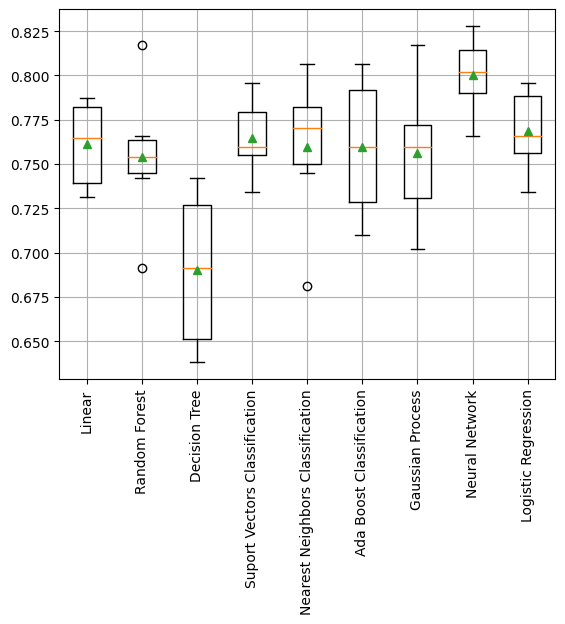

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot(results, labels = models.keys(), showmeans = True)
plt.xticks(rotation = 90)
plt.grid()
plt.show()

In [ ]:
neural_network = MLPClassifier()
neural_network.fit(X_train_stand, y_train)

logreg_auc_score = roc_auc_score(y_test, neural_network.predict_proba(X_test_stand)[:, 1])
print(f'\nAUC score: {logreg_auc_score:.4f}')
print()

y_pred = neural_network.predict(X_test_normed)

print(classification_report(y_test, y_pred))



AUC score: 0.7805

              precision    recall  f1-score   support

           1       0.76      1.00      0.87       143
           2       0.00      0.00      0.00        44

    accuracy                           0.76       187
   macro avg       0.38      0.50      0.43       187
weighted avg       0.58      0.76      0.66       187



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_star

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
parameters = {'solver': ['lbfgs', 'sgd', 'adam'],
              'alpha': 10.0 ** -np.arange(1, 10),
              'hidden_layer_sizes':np.arange(5, 22, 2),
              'random_state':[42]
              }


model = MLPClassifier()

kf = KFold(n_splits = 3, random_state = 42, shuffle = True)

grid = GridSearchCV(estimator=model, param_grid=parameters, cv=kf)

grid.fit(X_train_stand, y_train)

print(grid)

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=MLPClassifier(),
             param_grid={'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07, 1.e-08,
       1.e-09]),
                         'hidden_layer_sizes': array([ 5,  7,  9, 11, 13, 15, 17, 19, 21]),
                         'random_state': [42],
                         'solver': ['lbfgs', 'sgd', 'adam']})
0.8021390374331551
MLPClassifier(alpha=1e-07, hidden_layer_sizes=7, random_state=42,
              solver='lbfgs')


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
best_neural = grid.best_estimator_

# AUC score for tpot model
logreg_auc_score = roc_auc_score(y_test, best_neural.predict_proba(X_test_stand)[:, 1])
print(f'\nAUC score: {logreg_auc_score:.4f}')
print()

y_pred = best_neural.predict(X_test_normed)

print(classification_report(y_test, y_pred))


AUC score: 0.7622

              precision    recall  f1-score   support

           1       0.76      0.99      0.86       143
           2       0.00      0.00      0.00        44

    accuracy                           0.75       187
   macro avg       0.38      0.49      0.43       187
weighted avg       0.58      0.75      0.66       187



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [ ]:
parameters = {
    "n_neighbors": np.arange(5),
    "weights": ["uniform", "distance"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "leaf_size": np.arange(10, 51, 10),
    "p": [1, 2, 3, 5],

}

model = KNeighborsClassifier()

kf = KFold(n_splits = 3, random_state = 42, shuffle = True)

grid = GridSearchCV(estimator=model, param_grid=parameters, cv=kf)

grid.fit(X_train_stand, y_train)

print(grid)

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': array([10, 20, 30, 40, 50]),
                         'n_neighbors': array([0, 1, 2, 3, 4]),
                         'p': [1, 2, 3, 5],
                         'weights': ['uniform', 'distance']})
0.7843137254901961
KNeighborsClassifier(leaf_size=50, n_neighbors=2)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
480 fits failed out of a total of 2400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
480 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 213, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/

In [ ]:
best_knn = grid.best_estimator_

logreg_auc_score = roc_auc_score(y_test, best_knn.predict_proba(X_test_stand)[:, 1])
print(f'\nAUC score: {logreg_auc_score:.4f}')
print()

y_pred = best_knn.predict(X_test_normed)

print(classification_report(y_test, y_pred))


AUC score: 0.6786

              precision    recall  f1-score   support

           1       0.76      1.00      0.87       143
           2       0.00      0.00      0.00        44

    accuracy                           0.76       187
   macro avg       0.38      0.50      0.43       187
weighted avg       0.58      0.76      0.66       187



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `

In [ ]:
from sklearn.ensemble import VotingClassifier

estimators = [('knn',best_knn), ('neural', best_neural), ('lr', LogisticRegression())]

voting = VotingClassifier(estimators = estimators)

voting.fit(X_train_stand, y_train)

y_pred = best_knn.predict(X_test_normed)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.76      1.00      0.87       143
           2       0.00      0.00      0.00        44

    accuracy                           0.76       187
   macro avg       0.38      0.50      0.43       187
weighted avg       0.58      0.76      0.66       187



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Prec